In [1]:
# System libraries
import os
import sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


# Custom libraries
from utils.gpu_util import set_device
from utils.train_utils import get_optimizer, losses_and_metrics

# Helper libraries
import tensorflow as tf
import tensorflow_addons as tfa

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Set plot style
get_ipython().run_line_magic('matplotlib', 'inline')
set_device('gpu')

In [2]:
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict

In [3]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, BatchNormalization, ReLU, \
     Conv2D, Dense, MaxPool2D, AvgPool2D, GlobalAvgPool2D, Concatenate, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.initializers import he_uniform

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Choose a dataset method of 1, 2 or 3

## 1. Load Tensorflow datasets

In [4]:
import tensorflow_datasets as tfds

In [5]:
#train, valid = tfds.load('mnist', split=['train', 'test'], as_supervised=True, batch_size=64)
[train, valid], info = tfds.load('cifar10', split=['train', 'test'], as_supervised=True, batch_size=64, with_info=True)

In [6]:
def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255., label

train = train.map(normalize_img)
train_ds = train.map(lambda x, y: (x, tf.one_hot(y, depth=10)))

valid = valid.map(normalize_img)
valid_ds = valid.map(lambda x, y: (x, tf.one_hot(y, depth=10)))

In [7]:
print("Dataset cardinality")
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(valid_ds).numpy())

Dataset cardinality
782
157


In [8]:
print(info.features['image'].shape)

(32, 32, 3)


In [9]:
image_size = info.features['image'].shape

## 2. tf Data

In [4]:
from glob import glob

In [5]:
data_dir = '../dataset/plants-water'

In [6]:
list_ds = tf.data.Dataset.list_files(data_dir+ '/*/*', shuffle=False)# get the count of image files in the train directory

In [7]:
list_ds = list_ds.shuffle(200, reshuffle_each_iteration=False)

In [8]:
for f in list_ds.take(5):
    print(f.numpy())

b'../dataset/plants-water/plants/2Adr46TTPkI.jpg'
b'../dataset/plants-water/water/4KV3SKyHNjE.jpg'
b'../dataset/plants-water/plants/0gNVyfQMRVI.jpg'
b'../dataset/plants-water/water/2U890s9L77g.jpg'
b'../dataset/plants-water/plants/v-quTqXIQEo.jpg'


In [9]:
class_names = [item.split('/')[-1:][0] for item in glob(data_dir+'/*') ]

In [10]:
class_names

['plants', 'water']

In [11]:
train_ds = list_ds.skip(30)
valid_ds = list_ds.take(30).skip(15)
test_ds = list_ds.take(15)

In [10]:
train_len = tf.data.experimental.cardinality(train_ds).numpy()
valid_len = tf.data.experimental.cardinality(valid_ds).numpy()
print(train_len)
print(valid_len)

90
15


In [12]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    one_hot = parts[-2] == class_names
    # Integer encode the label
    return tf.one_hot(tf.argmax(one_hot), depth=2)

In [13]:
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.per_image_standardization(img)
    # resize the image to the desired size
    return img

In [14]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [15]:
train_ds = train_ds.map(process_path)
valid_ds = valid_ds.map(process_path)
test_ds = test_ds.map(process_path)

In [16]:
train_ds = train_ds.batch(10)
valid_ds = valid_ds.batch(15)
test_ds = test_ds.batch(15)

In [17]:
train_img_batch, train_label_batch = next(iter(train_ds))
valid_img_batch, valid_label_batch = next(iter(valid_ds))
test_img_batch, test_label_batch = next(iter(test_ds))

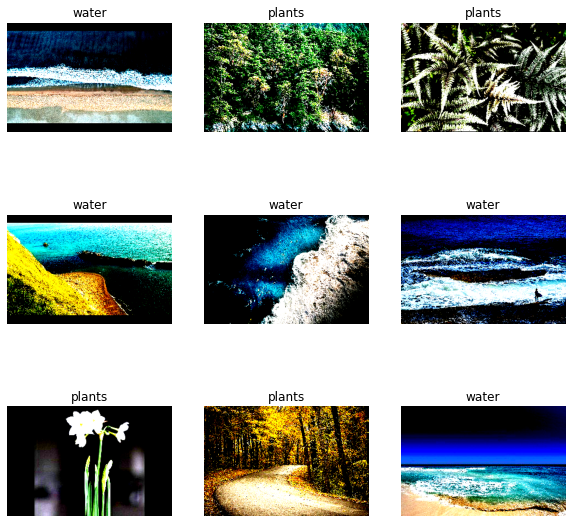

In [18]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(train_img_batch[i].numpy()/255)
    label = tf.argmax(train_label_batch[i])
    plt.title(class_names[label])
    plt.axis("off")

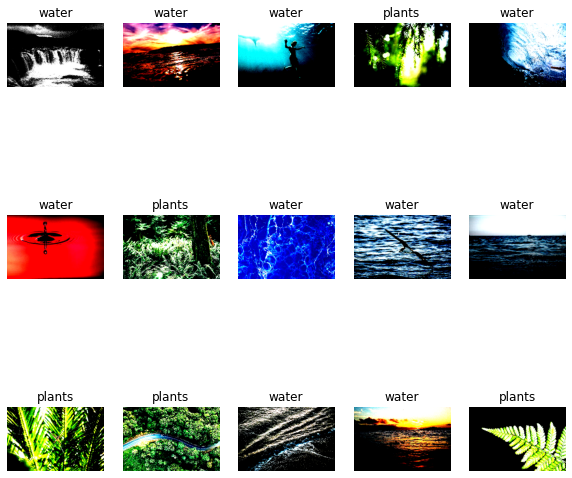

In [19]:
plt.figure(figsize=(10, 10))
for i in range(15):
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(valid_img_batch[i].numpy()/255)
    label = tf.argmax(valid_label_batch[i])
    plt.title(class_names[label])
    plt.axis("off")

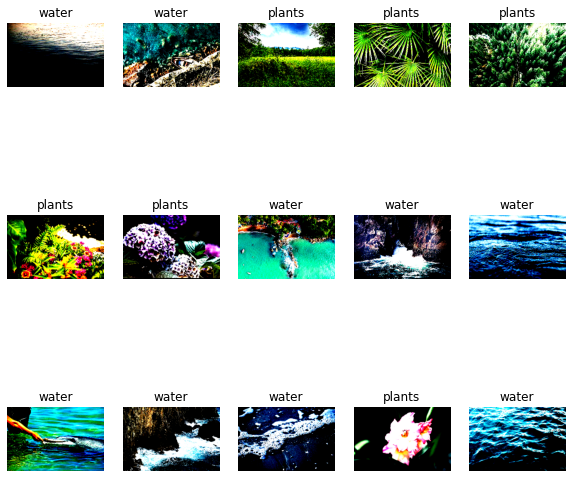

In [20]:
plt.figure(figsize=(10, 10))
for i in range(15):
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(test_img_batch[i].numpy()/255)
    label = tf.argmax(test_label_batch[i])
    plt.title(class_names[label])
    plt.axis("off")

## 3. Generators

In [28]:
generator = ImageDataGenerator(rescale=1. / 255, validation_split=0.2)

In [31]:
train = generator.flow_from_directory(directory='../dataset/plants-water/', target_size=(200, 300),
                                      color_mode='rgb',classes=['plants', 'water'], batch_size=10, save_format='jpg', subset="training")
valid = generator.flow_from_directory(directory='../dataset/plants-water/', target_size=(200, 300),
                                      color_mode='rgb',classes=['plants', 'water'], batch_size=20, save_format='jpg', subset="validation")

Found 96 images belonging to 2 classes.
Found 24 images belonging to 2 classes.


## 4. Train Models

#### Simple model for tfds datasets

In [17]:
def get_simple_model(image_size):
    model = Sequential()

    model.add(BatchNormalization(input_shape=([*image_size])))
    model.add(Conv2D(12, (5, 5), padding='valid', strides=(1,1),
                    activation='relu'))

    model.add(BatchNormalization())
    model.add(Conv2D(24, (3, 3), padding='valid', strides=(2,2), activation='relu'))
    model.add(Conv2D(24, (3, 3), padding='valid', strides=(1,1), activation='relu'))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(10, activation='softmax'))

    return model

In [ ]:
model = get_simple_model(image_size)

In [ ]:
optimizer = get_optimizer(0.001, 'adam')
model.compile(optimizer=optimizer, loss='categorical_crossentropy',
              metrics=[tfa.metrics.F1Score(num_classes=10, average='macro'), 'acc'])

results = model.fit(train_ds,
                    validation_data=valid_ds,
                    epochs=10,
                    verbose=2)#, callbacks=[early_stopping(), model_chpnt()])

### Trees-Water model

In [25]:
from tensorflow.keras import Model

### Construct a DenseNet type architecture

In [46]:
def bn_rl_conv(x, filters, kernel_size):
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               padding='same')(x)
    return x

def dense_block(tensor, k, reps):
    for _ in range(reps):
        x = bn_rl_conv(tensor, filters=4*k, kernel_size=1)
        x = bn_rl_conv(x, filters=k, kernel_size=3)
        tensor = Concatenate()([tensor, x])
    return tensor

def transition_layer(x, theta):
    f = int(tf.keras.backend.int_shape(x)[-1] * theta)
    x = bn_rl_conv(x, filters=f, kernel_size=1)
    x = AvgPool2D(pool_size=2, strides=2, padding='same')(x)
    return x

def get_trees_water_model(image_size):
    
    k = 4
    theta = 0.5
    repetitions = 1, 1

    input = Input(shape=[*image_size])

    x = Conv2D(2*k, 7, strides=2, padding='same')(input)
    x = MaxPool2D(3, strides=2, padding='same')(x)

    for reps in repetitions:
        d = dense_block(x, k, reps)
        x = transition_layer(d, theta)

    x = GlobalAvgPool2D()(d)

    output = Dense(2, activation='softmax')(x)
    model = Model(input, output)

    return model

## 4a. Train with AutoDiff Gradient Tape

In [47]:
optimizer = get_optimizer(0.0001, 'adam')
results = defaultdict(list)
epochs = 300

# Get losses and metrics
loss_fn, train_loss, train_accuracy, valid_loss, valid_accuracy, precision, recall, auc, train_f1, valid_f1 = losses_and_metrics(2)
model = get_trees_water_model([200,300,3])
#model = get_simple_model([200,300,3])

@tf.function
def training_graph(x, y, training):
    """Training graph starts a gradient tape
    and runs training and validation procedure

    Arguments:
        x: list, images from a batch
        y: list, labels from a batch
        training: bool, train or validation
    """
    
    with tf.GradientTape() as tape:
        """Run auto differentiation with GradientTape
        """
        #Forward pass
        logits = model(x, training=training)
        #Compute loss
        loss = loss_fn(y, logits)

    if training:  # back-propagation
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        # Update train metrics
        train_loss.update_state(loss)
        train_accuracy.update_state(y, logits)
        train_f1.update_state(y_true=y, y_pred=logits)

    else:  # inference
        valid_loss(loss)
        valid_accuracy(y, logits)
        valid_f1.update_state(y_true=y, y_pred=logits)
        
# Training-Validation process
for epoch in range(1, epochs+1):

    #pb_train = tf.keras.utils.Progbar(90//10)

    for i, (x, y) in enumerate(train_ds):

        '''
        if self.augment:
            x = tf.squeeze(x)
            #x = tf.reshape(x[:,:,:], [x.shape[0]*x.shape[1]*x.shape[2], 200, 300, 3])
            x = tf.reshape(x, shape=[-1, 200, 300, self.batch_size])
            print(x.shape)
        '''
        training_graph(x, y, True)
        #pb_train.update(i+1)
        
    for i, (x, y) in enumerate(valid_ds):
        training_graph(x, y, False)     
        
    # Print epoch status
    if epoch % 10 == 0:
        
        train_status_msg = "Training Loss: {:.3f}, Acc: {:.2f}%, f1: {:.3f} | Validation Loss: {:.3f}, Acc: {:.2f}%, f1: {:.3f}\n"
        
        print("Epoch {}/{}".format(epoch,epochs))
        print(train_status_msg.format(train_loss.result(), train_accuracy.result()*100, train_f1.result().numpy(),
                                  valid_loss.result(), valid_accuracy.result()*100, valid_f1.result().numpy()))

    # Keep results for plotting
    results['loss'].append(train_loss.result().numpy())
    results['accuracy'].append(train_accuracy.result().numpy())
    results['val_loss'].append(valid_loss.result().numpy())
    results['val_accuracy'].append(valid_accuracy.result().numpy())
    results['train_f1'].append(train_f1.result().numpy())
    results['valid_f1'].append(valid_f1.result().numpy())
                   
    train_loss.reset_states()
    train_accuracy.reset_states()
    valid_loss.reset_states()
    valid_accuracy.reset_states()
    precision.reset_states()

Epoch 10/300
Training Loss: 0.659, Acc: 63.33%, f1: 0.443 | Validation Loss: 0.685, Acc: 66.67%, f1: 0.455

Epoch 20/300
Training Loss: 0.588, Acc: 76.67%, f1: 0.616 | Validation Loss: 0.655, Acc: 60.00%, f1: 0.534

Epoch 30/300
Training Loss: 0.554, Acc: 81.11%, f1: 0.682 | Validation Loss: 0.622, Acc: 73.33%, f1: 0.556

Epoch 40/300
Training Loss: 0.535, Acc: 81.11%, f1: 0.715 | Validation Loss: 0.586, Acc: 80.00%, f1: 0.606

Epoch 50/300
Training Loss: 0.521, Acc: 82.22%, f1: 0.736 | Validation Loss: 0.566, Acc: 80.00%, f1: 0.645

Epoch 60/300
Training Loss: 0.510, Acc: 83.33%, f1: 0.753 | Validation Loss: 0.548, Acc: 86.67%, f1: 0.679

Epoch 70/300
Training Loss: 0.501, Acc: 84.44%, f1: 0.765 | Validation Loss: 0.536, Acc: 73.33%, f1: 0.693

Epoch 80/300
Training Loss: 0.493, Acc: 84.44%, f1: 0.775 | Validation Loss: 0.527, Acc: 73.33%, f1: 0.699

Epoch 90/300
Training Loss: 0.485, Acc: 84.44%, f1: 0.783 | Validation Loss: 0.520, Acc: 73.33%, f1: 0.704

Epoch 100/300
Training Loss:

In [21]:
import matplotlib.pyplot as plt
from matplotlib import rc

def plot_training(results, epochs):

    plt.style.use(['dark_background', 'bmh'])
    rc('figure', figsize=(8, 8), max_open_warning=False)
    rc('axes', facecolor='none')

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8))

    ax1.plot(results['accuracy'])
    ax1.plot(results['val_accuracy'])
    # mpl.pyplot.xticks(np.arange(1, 2, step=1))  # Set label locations.
    ax1.set_xlim(1, epochs-1)
    ax1.grid()
    ax1.set(ylabel="Accuracy")
    ax1.legend(['Training Accuracy', 'Validation Accuracy'])

    ax2.plot(results['loss'])
    ax2.plot(results['val_loss'])
    # mpl.pyplot.xticks(np.arange(1, 2, step=1))  # Set label locations.
    ax2.set_xlim(1, epochs-1)
    ax2.grid()

    ax2.set(ylabel="Loss")
    ax2.legend(['Training Loss', 'Validation Loss'])
    
    ax3.plot(results['train_f1'])
    ax3.plot(results['valid_f1'])
    # mpl.pyplot.xticks(np.arange(1, 2, step=1))  # Set label locations.
    ax3.set_xlim(1, epochs-1)
    ax3.grid()
    ax3.set(ylabel="F1")
    ax3.legend(['Training F1', 'Validation F1'])    

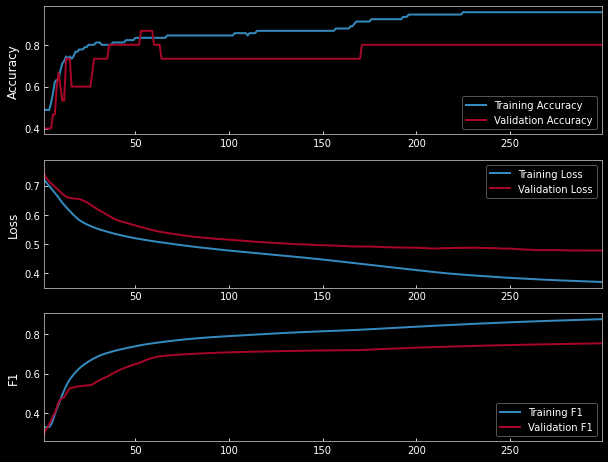

In [48]:
plot_training(results, epochs)

## 4b Train with Keras fit

In [37]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [49]:
model = get_trees_water_model([200,300,3])
optimizer = get_optimizer(0.0001, 'adam')
model.compile(optimizer=optimizer, loss='categorical_crossentropy',
              metrics=[tfa.metrics.F1Score(num_classes=2, average='macro'), 'acc'])

results = model.fit(train_ds,
                    validation_data=valid_ds,
                    epochs=200,
                    verbose=2,
                   callbacks=EarlyStopping(monitor='val_loss', patience=4))

Epoch 1/200
9/9 - 1s - loss: 0.7774 - f1_score: 0.3284 - acc: 0.4889 - val_loss: 1.1122 - val_f1_score: 0.2857 - val_acc: 0.4000
Epoch 2/200
9/9 - 0s - loss: 0.7507 - f1_score: 0.3284 - acc: 0.4889 - val_loss: 0.9281 - val_f1_score: 0.2857 - val_acc: 0.4000
Epoch 3/200
9/9 - 0s - loss: 0.7285 - f1_score: 0.3284 - acc: 0.4889 - val_loss: 0.8510 - val_f1_score: 0.2857 - val_acc: 0.4000
Epoch 4/200
9/9 - 0s - loss: 0.7083 - f1_score: 0.3284 - acc: 0.4889 - val_loss: 0.8057 - val_f1_score: 0.2857 - val_acc: 0.4000
Epoch 5/200
9/9 - 0s - loss: 0.6905 - f1_score: 0.3971 - acc: 0.5222 - val_loss: 0.7742 - val_f1_score: 0.3541 - val_acc: 0.4000
Epoch 6/200
9/9 - 0s - loss: 0.6746 - f1_score: 0.4518 - acc: 0.5444 - val_loss: 0.7505 - val_f1_score: 0.3541 - val_acc: 0.4000
Epoch 7/200
9/9 - 0s - loss: 0.6600 - f1_score: 0.5075 - acc: 0.5778 - val_loss: 0.7314 - val_f1_score: 0.3541 - val_acc: 0.4000
Epoch 8/200
9/9 - 0s - loss: 0.6471 - f1_score: 0.5413 - acc: 0.5889 - val_loss: 0.7159 - val_f1_

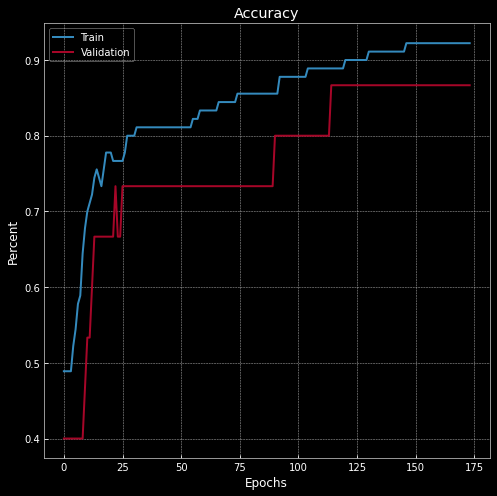

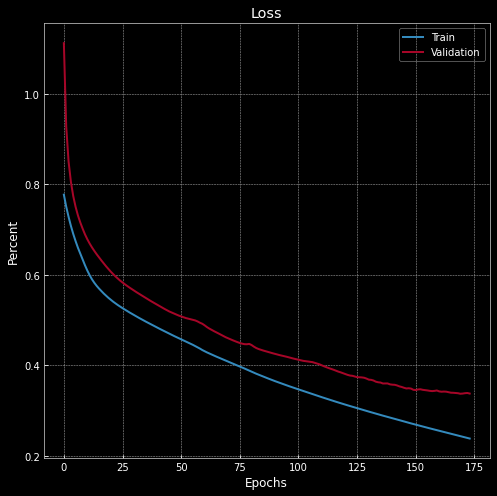

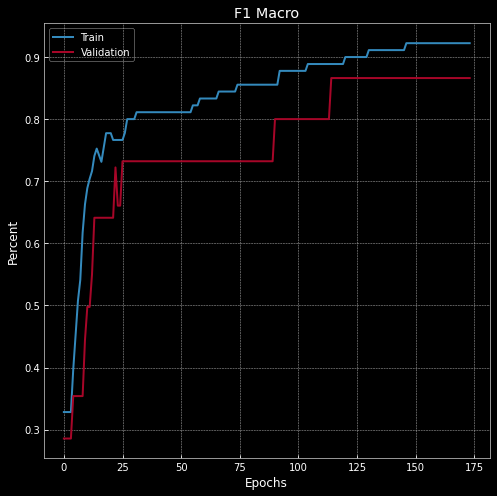

In [50]:
# Plot results in accuracy and loss metrics
plt.figure(1)
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Percent')
plt.legend(['Train','Validation'])

plt.figure(2)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Percent')
plt.legend(['Train','Validation'])

plt.figure(3)
plt.plot(results.history['f1_score'])
plt.plot(results.history['val_f1_score'])
plt.title('F1 Macro')
plt.xlabel('Epochs')
plt.ylabel('Percent')
plt.legend(['Train','Validation'])

In [51]:
model.save('model/plant-water-model.h5',save_format='h5')

In [52]:
valid_preds = model.predict(valid_ds)

In [53]:
true_y = []
for _, y in valid_ds.take(15):
    true_y.append(np.argmax(y, axis=1))
    y = np.concatenate(true_y)

In [54]:
model.evaluate(valid_ds)

1/1 [==============================] - 0s 3ms/step - loss: 0.3377 - f1_score: 0.8661 - acc: 0.8667


[0.337743878364563, 0.8660714626312256, 0.8666666746139526]

In [55]:
cm = confusion_matrix(y, np.argmax(valid_preds, axis=1))
cm

array([[7, 1],
       [1, 6]])

#### Test set

In [56]:
eval_loss, eval_f1, eval_acc  = model.evaluate(test_ds)

1/1 [==============================] - 0s 3ms/step - loss: 0.2964 - f1_score: 0.9321 - acc: 0.9333


In [57]:
print("Model loss={:.4f}, accuracy: {:.2f}%".format(eval_loss,eval_acc * 100))

Model loss=0.2964, accuracy: 93.33%


In [58]:
predictions = model.predict(test_ds)
predicted_classes = np.argmax(predictions,axis=1)

In [59]:
test_img, test_label = next(iter(test_ds))

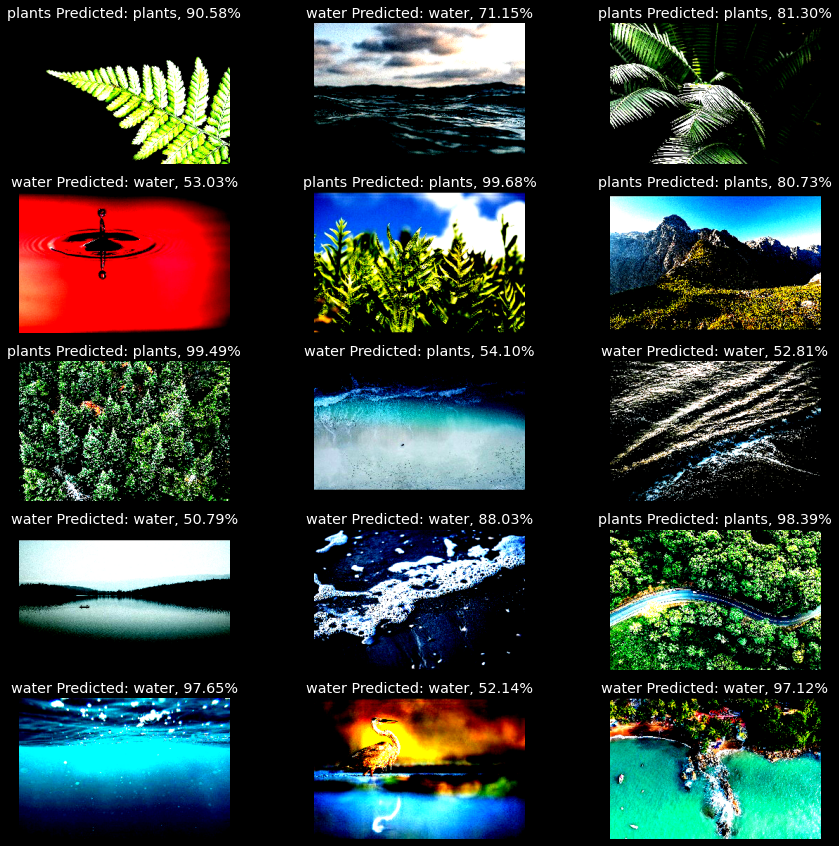

In [60]:
plt.figure(figsize=(15, 15))
for i in range(15):
    ax = plt.subplot(5, 3, i + 1,)
    plt.imshow(test_img[i].numpy()/255)
    
    label = np.argmax(test_label[i].numpy())

    pred_label = predicted_classes[i]    
    m = "{} Predicted: {}, {:.2f}%".format(class_names[label], class_names[pred_label], predictions[i][pred_label]*100)
    plt.title(m)
    plt.axis("off")

### Inference

In [61]:
from tensorflow.keras.models import load_model

### Load test folder and create a pipeline

In [62]:
test_dir = '../dataset/test'

In [63]:
inference_ds = tf.data.Dataset.list_files(test_dir + '/*', shuffle=False)# get the count of image files in the train directory

#### Preprocess images

In [64]:
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img,[200,300], preserve_aspect_ratio=False)
    #img = tf.image.per_image_standardization(img)
    # resize the image to the desired size
    return img

def process_path(file_path):
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, file_path

#### Load images

In [65]:
infer_images = inference_ds.map(process_path)

#### Load trained model

In [66]:
trained_model = load_model('model/plant-water-model.h5',compile=False)

#### Run inference 

In [67]:
inference_predicted_class = []
inference_predictions = []
results = {}
for infer_img, img_name in infer_images:
    preds = trained_model.predict(tf.expand_dims(infer_img, axis=0))
    inference_predicted_class.append(np.argmax(preds))
    inference_predictions.append(preds[0][np.argmax(preds)])
    
    results[str(img_name.numpy().decode('utf8').split('/')[-1])] = {"class":int(np.argmax(preds)), "prob":float(preds[0][np.argmax(preds)])}

In [68]:
results

{'-1lMrIXAn6Q.jpg': {'class': 1, 'prob': 0.6731923818588257},
 '-2ii0_ctxpQ.jpg': {'class': 0, 'prob': 0.7192543745040894},
 '-3LtGq_RPcY.jpg': {'class': 0, 'prob': 0.7015040516853333},
 '-3uIUqsR-Rw.jpg': {'class': 1, 'prob': 0.896124005317688},
 '-6JK87e42iQ.jpg': {'class': 1, 'prob': 0.7247390151023865},
 '-6h-oYfdZDA.jpg': {'class': 0, 'prob': 0.6795117855072021},
 '-9SsJ2jHnkg.jpg': {'class': 1, 'prob': 0.7283690571784973},
 '0-dy5lOmnMs.jpg': {'class': 1, 'prob': 0.9298789501190186},
 '00bdG0g6CiE.jpg': {'class': 1, 'prob': 0.982285737991333},
 '10IC1G_SVzE.jpg': {'class': 1, 'prob': 0.9101209044456482},
 '29SqSdfvN_A.jpg': {'class': 1, 'prob': 0.6327372789382935},
 '_583eiIT_84.jpg': {'class': 0, 'prob': 0.9780288338661194},
 '_9rJv47SMXQ.jpg': {'class': 0, 'prob': 0.5613241195678711}}

#### Plot results

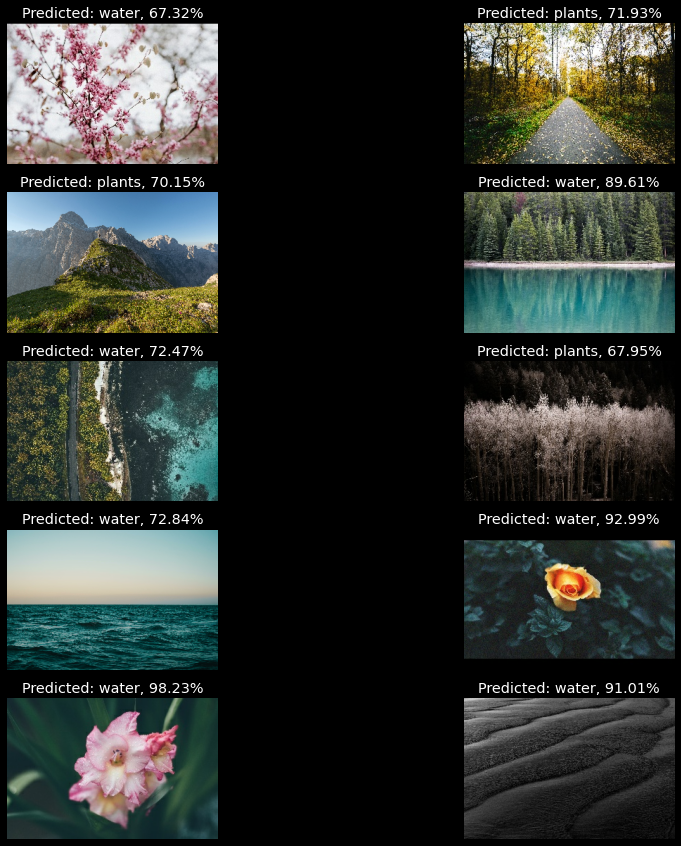

In [69]:
plt.figure(figsize=(15, 15))
for i, (infer_img, img_name) in enumerate(infer_images.take(10)):
    ax = plt.subplot(5, 2, i + 1)
    plt.imshow(infer_img.numpy()/255)
    
    # Find the predicted class from predictions
    m = "Predicted: {}, {:.2f}%".format(class_names[inference_predicted_class[i]], inference_predictions[i]*100)
    plt.title(m)
    plt.axis("off")

In [213]:
import json

In [237]:
json.dump(results, open("results.json","w"))

In [218]:
results

{'-3LtGq_RPcY.jpg': {'class': 0, 'prob': [0.6494296]},
 '-3uIUqsR-Rw.jpg': {'class': 1, 'prob': [0.86247015]},
 '-6JK87e42iQ.jpg': {'class': 0, 'prob': [0.65621585]},
 '-9SsJ2jHnkg.jpg': {'class': 1, 'prob': [0.8560468]},
 '10IC1G_SVzE.jpg': {'class': 1, 'prob': [0.6932683]},
 '29SqSdfvN_A.jpg': {'class': 1, 'prob': [0.5895437]}}